In [1]:
from appgeopy import *
from my_packages import *

In [2]:
def get_slope(input_series, force=True):
    fulltime_arr = datetime_handle.get_fulltime(input_series.index)
    fulltime_timeseries = datetime_handle.fulltime_table(
        df=input_series, fulltime_series=fulltime_arr
    )
    linear_trend, slope = analysis.get_linear_trend(
        series=fulltime_timeseries, force_zero_intercept=force
    )
    return linear_trend, slope

In [3]:
# load timeseries of cumulative displacement of all points
cumdisp_df = pd.read_pickle(
    r"D:\1000_SCRIPTS\003_Project002\20250917_GTWR002\2_KrigingInterpolation\5_PostKriging\Monthly_CUMDISP_saveqgis_Oct2025.xz"
)
cumdisp_df = cumdisp_df.set_index("PointKey")
show(cumdisp_df)

Loading ITables v2.4.5 from the internet... (need help?)


In [4]:
leveling_fpath = r"Yunlin_Leveling_2024_modified2016_2024.xz"
leveling_df = pd.read_pickle(leveling_fpath)
show(leveling_df)

Loading ITables v2.4.5 from the internet... (need help?)


In [5]:
points_byLeveling = pd.read_pickle(r"CUMDISP_in_YunlinLeveling_200m.xz")
show(points_byLeveling)

Loading ITables v2.4.5 from the internet... (need help?)


In [6]:
select_leveling_code = "NBI027"

# using the select benchmark code, we get the pointkey located within the leveling's buffer
pointkey_byCode = points_byLeveling.query("ALTCODE==@select_leveling_code")[
    "PointKey"
].tolist()

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# deal with Leveling survey timeseries
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


leveling_measure_cols = [
    col for col in leveling_df.columns if col.startswith("N")
]
leveling_timeseries = leveling_df.loc[
    select_leveling_code, leveling_measure_cols
]

leveling_timeseries = leveling_timeseries.astype(np.float64)

leveling_timeseries = (leveling_timeseries - leveling_timeseries.iloc[0]) * 1000

leveling_timeseries.index = pd.to_datetime(
    [idx[1:] for idx in leveling_timeseries.index]
)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# deal with CUMDISP timeseries
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

cumdisp_byLevelingCode = cumdisp_df.loc[pointkey_byCode, :]

cumdisp_measure_cols = [
    col for col in cumdisp_byLevelingCode.columns if col.startswith("D")
]

cumdisp_byLevelingCode = cumdisp_byLevelingCode.loc[:, cumdisp_measure_cols]

average_cumdisp_byLevelingCode = cumdisp_byLevelingCode.mean(axis=0)

# we add one day to convert datetime to the beginning of the month
average_cumdisp_byLevelingCode.index = [
    pd.to_datetime(idx[1:]) + relativedelta(days=1)
    for idx in average_cumdisp_byLevelingCode.index
]

new_columns = [
    pd.to_datetime(col[1:]) + relativedelta(days=1)
    for col in cumdisp_byLevelingCode.columns
]
cumdisp_byLevelingCode.columns = new_columns

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# calculate slope value for each
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# leveling timeseries
leveling_trend, leveling_slope = get_slope(leveling_timeseries)

# average cumdisp timeseries
cumdisp_trend, cumdisp_slope = get_slope(
    average_cumdisp_byLevelingCode, force=False
)

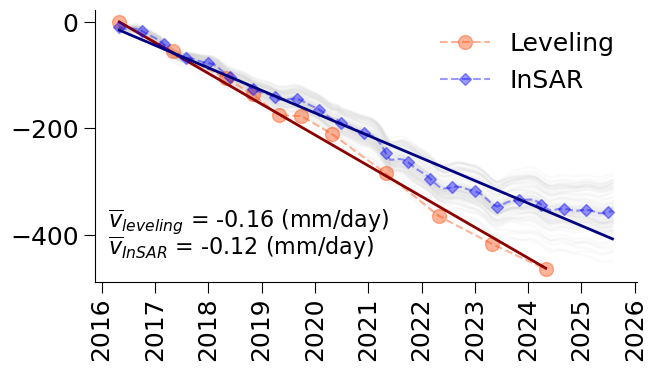

In [7]:
# fig = plt.figure(figsize=(21, 12))
fig = plt.figure(figsize=(7, 4))

ax = fig.add_subplot(111)
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
ax.plot(cumdisp_byLevelingCode.T, color="lightgrey", alpha=0.1)

ax.plot(
    leveling_timeseries,
    marker="o",
    ms=10,
    color="orangered",
    linestyle="--",
    label="Leveling",
    alpha=0.4,
)

ax.plot(leveling_trend, color="darkred", linestyle="-", lw=2)
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
ax.plot(
    average_cumdisp_byLevelingCode,
    marker="D",
    markevery=5,
    ls="--",
    color="blue",
    label="InSAR",
    alpha=0.4,
)

ax.plot(cumdisp_trend, color="navy", linestyle="-", lw=2)
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
ax.text(
    x=0.025,
    y=0.2,
    s=r"$\overline{v}_{leveling}$" + f" = {leveling_slope:.2f} (mm/day)",
    transform=ax.transAxes,
    fontsize=16,
)

ax.text(
    x=0.025,
    y=0.1,
    s=r"$\overline{v}_{InSAR}$" + f" = {cumdisp_slope:.2f} (mm/day)",
    transform=ax.transAxes,
    fontsize=16,
)
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

visualize.configure_axis(
    ax=ax,
    tick_direction="out",
    major_tick_length=8,
    minor_tick_length=4,
    hide_spines=["top", "right"],
)

visualize.configure_legend(ax=ax)

fig.autofmt_xdate(rotation=90, ha="center", which="major")
# visualize.save_figure(fig=fig, savepath="before_correction.png", dpi=300)

plt.show()

In [9]:
# load timeseries of cumulative displacement of all points
correct_cumdisp = pd.read_pickle(
    r"D:\1000_SCRIPTS\003_Project002\20250917_GTWR002\1_PrepareDatasets\LevelingBechmark\CORRECTED_Monthly_CUMDISP_CRFP_saveqgis_Oct2025.xz"
)
# correct_cumdisp = correct_cumdisp.set_index("PointKey")
show(correct_cumdisp)

Loading ITables v2.4.5 from the internet... (need help?)


In [14]:
correct_cumdisp_byLevelingCode = correct_cumdisp.loc[pointkey_byCode, :]

correct_cumdisp_measure_cols = [
    col for col in correct_cumdisp_byLevelingCode.columns if col.startswith("D")
]

correct_cumdisp_byLevelingCode = correct_cumdisp_byLevelingCode.loc[
    :, correct_cumdisp_measure_cols
]

average_correct_cumdisp_byLevelingCode = correct_cumdisp_byLevelingCode.mean(
    axis=0
)

# we add one day to convert datetime to the beginning of the month
average_correct_cumdisp_byLevelingCode.index = [
    pd.to_datetime(idx[1:]) + relativedelta(days=1)
    for idx in average_correct_cumdisp_byLevelingCode.index
]

new_columns2 = [
    pd.to_datetime(col[1:]) + relativedelta(days=1)
    for col in correct_cumdisp_byLevelingCode.columns
]
correct_cumdisp_byLevelingCode.columns = new_columns2

# average cumdisp timeseries
correct_cumdisp_trend, correct_cumdisp_slope = get_slope(
    average_correct_cumdisp_byLevelingCode, force=False
)

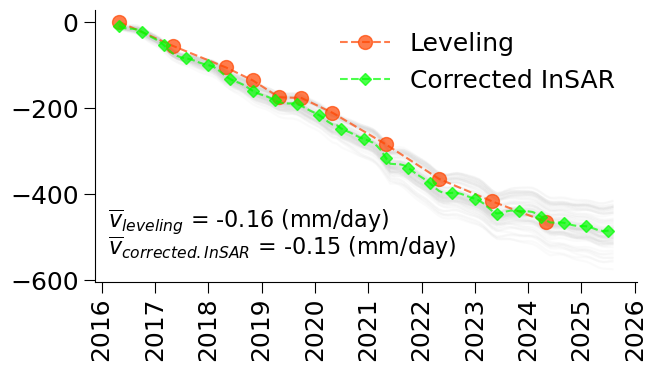

In [25]:
# fig = plt.figure(figsize=(21, 12))
fig = plt.figure(figsize=(7, 4))

ax = fig.add_subplot(111)
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
ax.plot(correct_cumdisp_byLevelingCode.T, color="lightgrey", alpha=0.1)

ax.plot(
    leveling_timeseries,
    marker="o",
    ms=10,
    color="orangered",
    linestyle="--",
    label="Leveling",
    alpha=0.7,
)

# ax.plot(leveling_trend, color="darkred", linestyle="-", lw=2)
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
ax.plot(
    average_correct_cumdisp_byLevelingCode,
    marker="D",
    markevery=5,
    ls="--",
    color="lime",
    label="Corrected InSAR",
    alpha=0.7,
)

# ax.plot(correct_cumdisp_trend, color="darkgreen", linestyle="-", lw=2)
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
ax.text(
    x=0.025,
    y=0.2,
    s=r"$\overline{v}_{leveling}$" + f" = {leveling_slope:.2f} (mm/day)",
    transform=ax.transAxes,
    fontsize=16,
)

ax.text(
    x=0.025,
    y=0.1,
    s=r"$\overline{v}_{corrected.InSAR}$"
    + f" = {correct_cumdisp_slope:.2f} (mm/day)",
    transform=ax.transAxes,
    fontsize=16,
)
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

visualize.configure_axis(
    ax=ax,
    tick_direction="out",
    major_tick_length=8,
    minor_tick_length=4,
    hide_spines=["top", "right"],
)

visualize.configure_legend(ax=ax)

fig.autofmt_xdate(rotation=90, ha="center", which="major")
visualize.save_figure(fig=fig, savepath="after_correction_2.png", dpi=300)

plt.show()